Install pgmpy

In [ ]:
!pip install pgmpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Import data

In [ ]:
import pandas as pd

# Replace 'path_to_your_dataset.xlsx' with the actual path to your dataset
data_path = '/content/Synthetic_Drug_Dataset-2.xlsx'
data = pd.read_excel(data_path)

# Check the first few rows to ensure it's loaded correctly
print(data.head())


   Drug ID      LogP     mw  Polar Surface Area  H Bond Donors  \
0        4  3.996714  75.11           39.615731              3   
1       75  3.361736  73.09           64.483867              2   
2      174  4.147689  62.07           66.432137              0   
3      215  5.023030  73.09           54.943068              0   
4      363  3.265847  59.07           70.967857              1   

   H Bond Acceptors CACO2 Permeability BBB Permeability     HIA  \
0                 4               High              Low    High   
1                 5             Medium             High  Medium   
2                 2               High           Medium  Medium   
3                 8               High           Medium     Low   
4                 3               High           Medium  Medium   

  Activity Against Target Toxicity             cmpdname      mf  heavycnt  \
0                  Active       No   1-Aminopropan-2-ol  C3H9NO         5   
1                  Active       No      3-Amin

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

# Define the structure of the Bayesian Network
model = BayesianNetwork([
    ('LogP', 'Activity Against Target'),
    ('mw', 'Activity Against Target'),
    ('Toxicity', 'Activity Against Target')
])


# Fit the model using the Maximum Likelihood Estimator
model.fit(data, estimator=MaximumLikelihoodEstimator)

# Print the learned CPTs
for cpd in model.get_cpds():
    print("CPT of {variable}:".format(variable=cpd.variable))
    print(cpd)


CPT of LogP:
+-------------------------+------+
| LogP(1.540329876120224) | 0.02 |
+-------------------------+------+
| LogP(1.586719755342202) | 0.02 |
+-------------------------+------+
| LogP(1.736959844637266) | 0.02 |
+-------------------------+------+
| LogP(1.775082167486967) | 0.02 |
+-------------------------+------+
| LogP(2.021478009632573) | 0.02 |
+-------------------------+------+
| LogP(2.075251813786543) | 0.02 |
+-------------------------+------+
| LogP(2.087696298664708) | 0.02 |
+-------------------------+------+
| LogP(2.171813951101569) | 0.02 |
+-------------------------+------+
| LogP(2.279156350028978) | 0.02 |
+-------------------------+------+
| LogP(2.349006422577697) | 0.02 |
+-------------------------+------+
| LogP(2.4422890710441)   | 0.02 |
+-------------------------+------+
| LogP(2.487168879665576) | 0.02 |
+-------------------------+------+
| LogP(2.591975924478789) | 0.02 |
+-------------------------+------+
| LogP(2.780155791605291) | 0.02 |
+------

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

data_path = '/content/Synthetic_Drug_Dataset-2.xlsx'
data = pd.read_excel(data_path)

# Adjusting the discretization strategy to quantiles
data['LogP_discrete'] = pd.qcut(data['LogP'], q=4, labels=['Very Low', 'Low', 'Medium', 'High'])
data['MW_discrete'] = pd.qcut(data['mw'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

model = BayesianNetwork([
    ('MW_discrete', 'Activity Against Target'),
    ('LogP_discrete', 'Activity Against Target')
])

model.fit(data, estimator=MaximumLikelihoodEstimator)

for cpd in model.get_cpds():
    print("CPT of {}:".format(cpd.variable))
    print(cpd)

# Checking the discretization outcome
print("Counts per category in MW_discrete:", data['MW_discrete'].value_counts())
print("Counts per category in LogP_discrete:", data['LogP_discrete'].value_counts())

# Handling missing states
evidence = {'LogP_discrete': 'High', 'MW_discrete': 'Medium'}
if all(state in model.get_cpds(var).state_names[var] for var, state in evidence.items()):
    inference = VariableElimination(model)
    result = inference.query(variables=['Activity Against Target'], evidence=evidence)
    print(result)
else:
    print("Missing state in evidence. Please adjust.")


CPT of MW_discrete:
+------------------------+------+
| MW_discrete(High)      | 0.18 |
+------------------------+------+
| MW_discrete(Low)       | 0.2  |
+------------------------+------+
| MW_discrete(Medium)    | 0.22 |
+------------------------+------+
| MW_discrete(Very High) | 0.2  |
+------------------------+------+
| MW_discrete(Very Low)  | 0.2  |
+------------------------+------+
CPT of Activity Against Target:
+-----------------------------------+-----+-------------------------+
| LogP_discrete                     | ... | LogP_discrete(Very Low) |
+-----------------------------------+-----+-------------------------+
| MW_discrete                       | ... | MW_discrete(Very Low)   |
+-----------------------------------+-----+-------------------------+
| Activity Against Target(Active)   | ... | 0.0                     |
+-----------------------------------+-----+-------------------------+
| Activity Against Target(Inactive) | ... | 1.0                     |
+-------------

In [ ]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.model_selection import KFold

# Load and prepare the data
data_path = '/content/Synthetic_Drug_Dataset-2.xlsx'
data = pd.read_excel(data_path)

# Check if 'Molecular Weight' and 'LogP' are in the DataFrame
assert 'mw' in data.columns and 'LogP' in data.columns, "Column names are incorrect or missing"

# Discretize 'LogP' and 'Molecular Weight'
data['LogP_discrete'] = pd.qcut(data['LogP'], q=4, duplicates='drop', labels=['Very Low', 'Low', 'Medium', 'High'])
data['MW_discrete'] = pd.qcut(data['mw'], q=5, duplicates='drop', labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Verify discretization
assert 'MW_discrete' in data.columns and 'LogP_discrete' in data.columns, "Discretization failed to create columns"

# Setting up the model
model = BayesianNetwork([
    ('MW_discrete', 'Activity Against Target'),
    ('LogP_discrete', 'Activity Against Target')
])

# Splitting the data for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # Ensure the model is fitted using the columns expected
    if 'MW_discrete' not in train_data.columns or 'LogP_discrete' not in train_data.columns:
        raise ValueError("Required columns are missing in the training data")

    model.fit(train_data, estimator=MaximumLikelihoodEstimator)
    inference = VariableElimination(model)

    # Predict and calculate accuracy
    correct_predictions = 0
    for _, row in test_data.iterrows():
        evidence = {'LogP_discrete': row['LogP_discrete'], 'MW_discrete': row['MW_discrete']}
        if any(e not in model.get_cpds(var).state_names[var] for var, e in evidence.items()):
            continue  # Skip if evidence state is not in the model
        prediction = inference.map_query(variables=['Activity Against Target'], evidence=evidence)
        if prediction['Activity Against Target'] == row['Activity Against Target']:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_data)
    scores.append(accuracy)

average_accuracy = sum(scores) / len(scores)
print("Average Cross-Validation Accuracy:", average_accuracy)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Average Cross-Validation Accuracy: 0.6000000000000001


In [ ]:
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score

# Assuming 'model' is already correctly set up and fitted with CPDs

# Setting up inference
inference = VariableElimination(model)

predictions = []
for _, row in data.iterrows():
    try:
        # Perform query
        result = inference.query(variables=['Activity Against Target'],
                                 evidence={'LogP_discrete': row['LogP_discrete'],
                                           'MW_discrete': row['MW_discrete']})
        # Extract the most probable state
        max_prob_index = np.argmax(result.values)
        predicted_state = result.state_names['Activity Against Target'][max_prob_index]
        predictions.append(predicted_state)
    except Exception as e:
        print(f"Error during inference: {e}")
        predictions.append(None)  # Append None for cases where inference fails

# Assuming 'Activity Against Target' in 'data' is the true labels
# Make sure to filter out None values before any comparisons or evaluations
valid_predictions = [pred for pred in predictions if pred is not None]
valid_labels = data['Activity Against Target'][len(predictions) - len(valid_predictions):]

# Evaluation
if len(valid_predictions) > 0 and len(valid_predictions) == len(valid_labels):
    accuracy = accuracy_score(valid_labels, valid_predictions)
    print(f"Accuracy: {accuracy:.2f}")
else:
    print("Insufficient valid predictions for accuracy calculation.")


Accuracy: 0.76


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions ensuring that each test instance has a corresponding prediction or placeholder
predictions = []
for index, row in test_data.iterrows():
    try:
        result = inference.query(variables=['Activity Against Target'], evidence={'LogP_discrete': row['LogP_discrete'], 'MW_discrete': row['MW_discrete']})
        max_prob_index = np.argmax(result.values)
        predicted_state = result.state_names['Activity Against Target'][max_prob_index]
        predictions.append(predicted_state)
    except Exception as e:
        print(f"Error during inference for index {index}: {e}")
        predictions.append(None)  # Append None if a prediction cannot be made

# Filter valid predictions and corresponding test labels
valid_predictions = [pred for pred in predictions if pred is not None]
valid_test_data = test_data.iloc[:len(valid_predictions)]['Activity Against Target']

# Debug prints to verify lengths
print(f"Total predictions made: {len(predictions)}")
print(f"Valid predictions count: {len(valid_predictions)}")
print(f"Test data count: {len(test_data)}")
print(f"Valid test data count: {len(valid_test_data)}")

# Calculate metrics if valid predictions are present
if len(valid_predictions) > 0 and len(valid_predictions) == len(valid_test_data):
    precision = precision_score(valid_test_data, valid_predictions, pos_label='Active')
    recall = recall_score(valid_test_data, valid_predictions, pos_label='Active')
    f1 = f1_score(valid_test_data, valid_predictions, pos_label='Active')
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1-Score: {:.2f}".format(f1))
else:
    print("Mismatch in the number of valid predictions and test labels or no valid predictions.")


Total predictions made: 10
Valid predictions count: 10
Test data count: 10
Valid test data count: 10
Precision: 0.40
Recall: 0.67
F1-Score: 0.50


In [ ]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Load and prepare the data
data_path = '/content/Synthetic_Drug_Dataset-2.xlsx'
data = pd.read_excel(data_path)

# Check if 'Molecular Weight' and 'LogP' are in the DataFrame
assert 'mw' in data.columns and 'LogP' in data.columns, "Column names are incorrect or missing"

# Discretize 'LogP' and 'Molecular Weight'
data['LogP_discrete'] = pd.qcut(data['LogP'], q=4, duplicates='drop', labels=['Very Low', 'Low', 'Medium', 'High'])
data['MW_discrete'] = pd.qcut(data['mw'], q=5, duplicates='drop', labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Verify discretization
assert 'MW_discrete' in data.columns and 'LogP_discrete' in data.columns, "Discretization failed to create columns"

# Setting up the model
model = BayesianNetwork([
    ('MW_discrete', 'Activity Against Target'),
    ('LogP_discrete', 'Activity Against Target')
])

# Splitting the data for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # Ensure the model is fitted using the columns expected
    if 'MW_discrete' not in train_data.columns or 'LogP_discrete' not in train_data.columns:
        raise ValueError("Required columns are missing in the training data")

    model.fit(train_data, estimator=MaximumLikelihoodEstimator)
    inference = VariableElimination(model)

    # Predict and calculate accuracy
    correct_predictions = 0
    for _, row in test_data.iterrows():
        evidence = {'LogP_discrete': row['LogP_discrete'], 'MW_discrete': row['MW_discrete']}
        if any(e not in model.get_cpds(var).state_names[var] for var, e in evidence.items()):
            continue  # Skip if evidence state is not in the model
        prediction = inference.map_query(variables=['Activity Against Target'], evidence=evidence)
        if prediction['Activity Against Target'] == row['Activity Against Target']:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_data)
    scores.append(accuracy)

average_accuracy = sum(scores) / len(scores)
print("Average Cross-Validation Accuracy:", average_accuracy)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Average Cross-Validation Accuracy: 0.6000000000000001


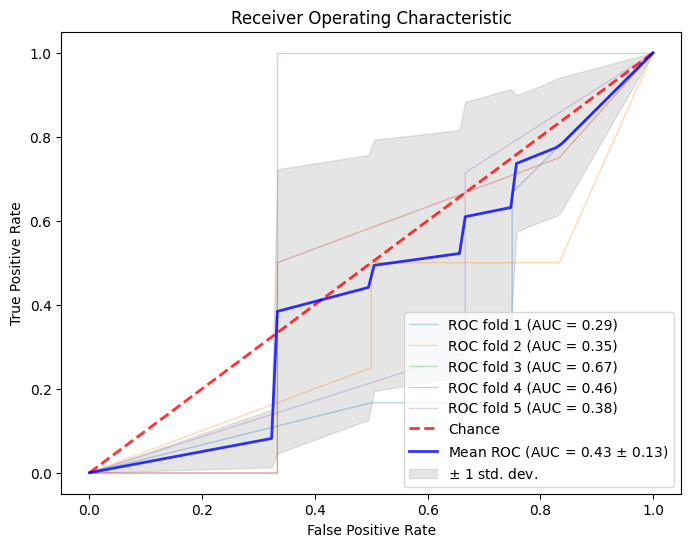

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load and prepare the data
data_path = '/content/Synthetic_Drug_Dataset-2.xlsx'
data = pd.read_excel(data_path)

# Check if 'Molecular Weight' and 'LogP' are in the DataFrame
assert 'mw' in data.columns and 'LogP' in data.columns, "Column names are incorrect or missing"

# Discretize 'LogP' and 'Molecular Weight'
data['LogP_discrete'] = pd.qcut(data['LogP'], q=4, duplicates='drop', labels=['Very Low', 'Low', 'Medium', 'High'])
data['MW_discrete'] = pd.qcut(data['mw'], q=5, duplicates='drop', labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Verify discretization
assert 'MW_discrete' in data.columns and 'LogP_discrete' in data.columns, "Discretization failed to create columns"

# Encoding the target variable
label_encoder = LabelEncoder()
data['Activity Against Target'] = label_encoder.fit_transform(data['Activity Against Target'])

# Setting up the model
model = BayesianNetwork([
    ('MW_discrete', 'Activity Against Target'),
    ('LogP_discrete', 'Activity Against Target')
])

# Splitting the data for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

plt.figure(figsize=(8, 6))

for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # Ensure the model is fitted using the columns expected
    if 'MW_discrete' not in train_data.columns or 'LogP_discrete' not in train_data.columns:
        raise ValueError("Required columns are missing in the training data")

    model.fit(train_data, estimator=MaximumLikelihoodEstimator)
    inference = VariableElimination(model)

    y_true = []
    y_score = []

    for _, row in test_data.iterrows():
        evidence = {'LogP_discrete': row['LogP_discrete'], 'MW_discrete': row['MW_discrete']}
        if any(e not in model.get_cpds(var).state_names[var] for var, e in evidence.items()):
            continue  # Skip if evidence state is not in the model
        prediction = inference.query(variables=['Activity Against Target'], evidence=evidence)
        prob_dist = prediction.values
        state_index = prediction.state_names['Activity Against Target'].index(row['Activity Against Target'])
        y_true.append(row['Activity Against Target'])
        y_score.append(prob_dist[state_index])  # Probability of 'Activity Against Target' being True

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(aucs), roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


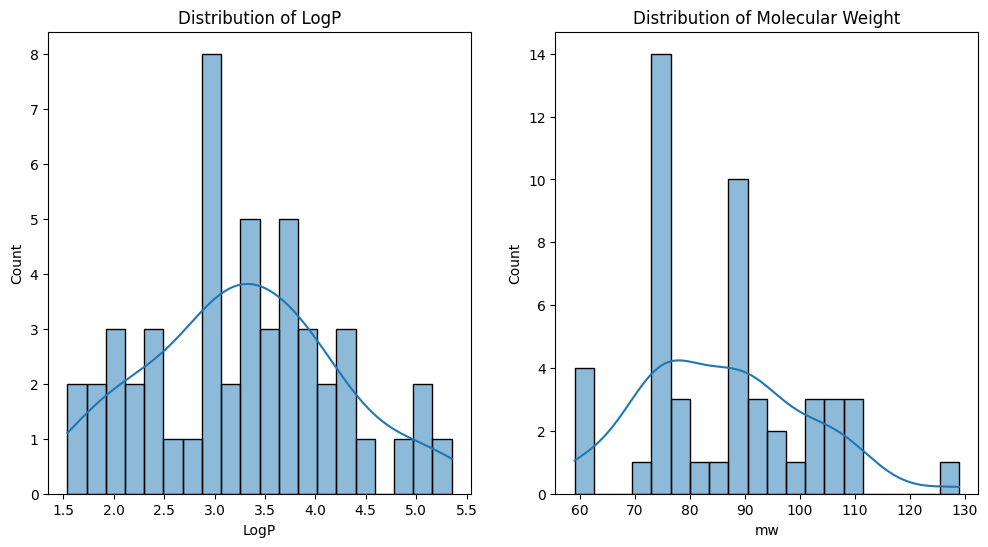

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your full dataset loaded with 'LogP' and 'Molecular Weight'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['LogP'], bins=20, kde=True)
plt.title('Distribution of LogP')

plt.subplot(1, 2, 2)
sns.histplot(data['mw'], bins=20, kde=True)
plt.title('Distribution of Molecular Weight')

plt.show()


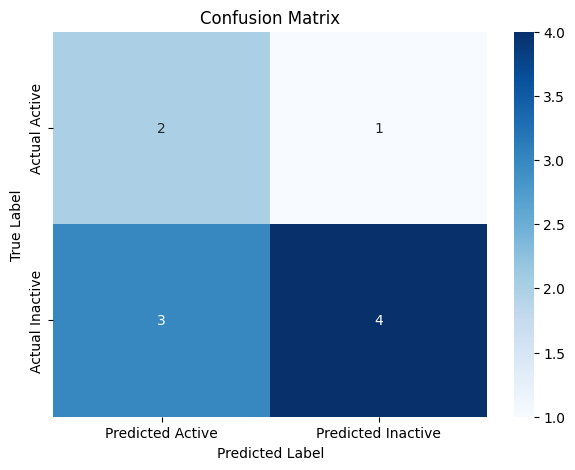

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pgmpy.inference import VariableElimination

# Assuming 'model' is your already trained Bayesian Network
inference = VariableElimination(model)

predictions = []
for index, row in test_data.iterrows():
    try:
        # Perform the inference. Make sure the evidence names match your model's variable names
        result = inference.query(variables=['Activity Against Target'],
                                 evidence={'LogP_discrete': row['LogP_discrete'],
                                           'MW_discrete': row['MW_discrete']})
        # Extract the most probable state
        max_prob_index = np.argmax(result.values)
        predicted_state = result.state_names['Activity Against Target'][max_prob_index]
        predictions.append(predicted_state)
    except Exception as e:
        print(f"Error during inference for index {index}: {e}")
        predictions.append(None)  # Append None for failed predictions

# Apply boolean mask for valid predictions
valid_mask = [pred is not None for pred in predictions]
valid_predictions = [pred for pred in predictions if pred is not None]
valid_test_data = test_data[valid_mask]['Activity Against Target']

# Verify correct lengths
if len(valid_predictions) != len(valid_test_data):
    print("Error: Mismatch in the number of valid predictions and test labels.")

# Proceed to generate and display the confusion matrix
if len(valid_predictions) == len(valid_test_data):
    cm = confusion_matrix(valid_test_data, valid_predictions, labels=['Active', 'Inactive'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Active', 'Predicted Inactive'], yticklabels=['Actual Active', 'Actual Inactive'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Error: The number of valid predictions does not match the number of labels in the filtered test data.")


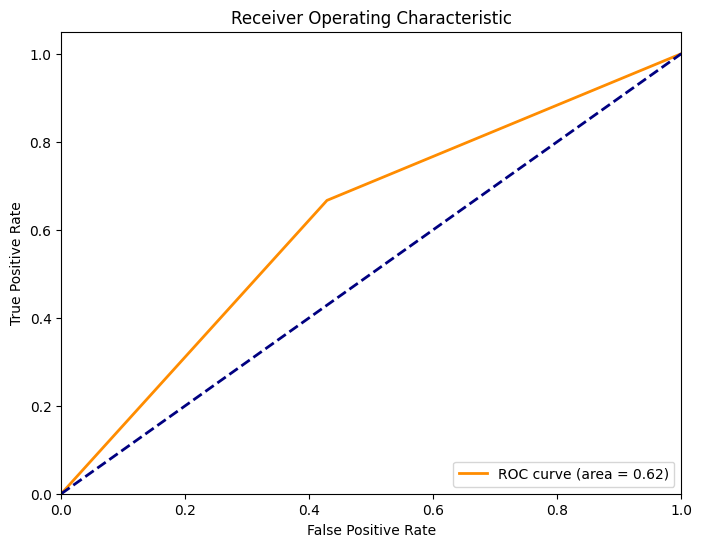

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming binary encoding of labels ('Active' = 1, 'Inactive' = 0) for 'valid_test_data' and 'valid_predictions'
fpr, tpr, thresholds = roc_curve(valid_test_data.map({'Active': 1, 'Inactive': 0}), [1 if p == 'Active' else 0 for p in valid_predictions])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


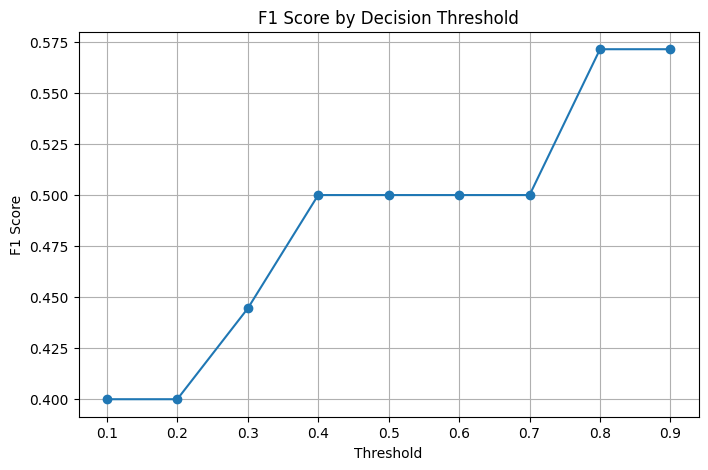

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from pgmpy.inference import VariableElimination

# Assuming 'model' is your Bayesian Network and 'test_data' is your dataset
inference = VariableElimination(model)

# Generate inference results
inference_results = []
for index, row in test_data.iterrows():
    try:
        result = inference.query(variables=['Activity Against Target'],
                                 evidence={'LogP_discrete': row['LogP_discrete'],
                                           'MW_discrete': row['MW_discrete']})
        inference_results.append(result)
    except Exception as e:
        print(f"Error during inference for index {index}: {e}")
        inference_results.append(None)

# Calculate F1 scores for varying thresholds
thresholds = np.linspace(0.1, 0.9, 9)
f1_scores = []

for thresh in thresholds:
    adjusted_predictions = []
    for result in inference_results:
        if result is not None:
            prob_active = result.values[result.state_names['Activity Against Target'].index('Active')]
            adjusted_predictions.append('Active' if prob_active > thresh else 'Inactive')
        else:
            adjusted_predictions.append('Inactive')  # Default if inference failed

    score = f1_score(test_data['Activity Against Target'], adjusted_predictions, pos_label='Active')
    f1_scores.append(score)

# Plotting F1 scores across thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 Score by Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


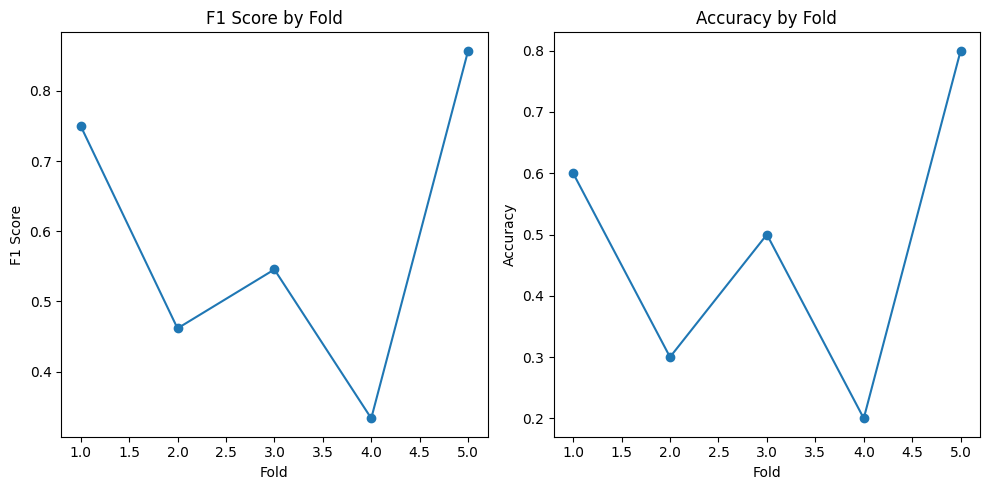

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns

# Load and preprocess your data
data_path = '/content/Synthetic_Drug_Dataset-2.xlsx'  # Change this path to your actual data file
data = pd.read_excel(data_path)
data['LogP_discrete'] = pd.qcut(data['LogP'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
data['MW_discrete'] = pd.qcut(data['mw'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Define the Bayesian Network structure and fit the model
def fit_bayesian_network(train_data):
    model = BayesianNetwork([('LogP_discrete', 'Activity Against Target'), ('MW_discrete', 'Activity Against Target')])
    model.fit(train_data, estimator=MaximumLikelihoodEstimator)
    return model

# Function to perform inference and return predictions
def evaluate_network(model, test_data):
    inference = VariableElimination(model)
    predictions = []
    actuals = test_data['Activity Against Target'].tolist()  # Collect actual labels for comparison

    for _, row in test_data.iterrows():
        try:
            result = inference.query(variables=['Activity Against Target'],
                                     evidence={'LogP_discrete': row['LogP_discrete'], 'MW_discrete': row['MW_discrete']})
            max_prob_index = np.argmax(result.values)
            predicted_state = result.state_names['Activity Against Target'][max_prob_index]
            predictions.append(predicted_state)
        except Exception as e:
            print(f"Error during inference: {e}")
            predictions.append(None)  # Append None for failed predictions
    return predictions, actuals

# Perform K-fold cross-validation
kf = KFold(n_splits=5)
f1_scores = []
accuracies = []

for train_index, test_index in kf.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    model = fit_bayesian_network(train_data)
    predictions, actuals = evaluate_network(model, test_data)

    # Remove None values from predictions for metric calculations
    filtered_predictions = [p for p in predictions if p is not None]
    filtered_actuals = [actuals[i] for i in range(len(predictions)) if predictions[i] is not None]

    f1 = f1_score(filtered_actuals, filtered_predictions, pos_label='Active')
    acc = accuracy_score(filtered_actuals, filtered_predictions)

    f1_scores.append(f1)
    accuracies.append(acc)

# Plotting F1 scores and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), f1_scores, marker='o')
plt.title('F1 Score by Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), accuracies, marker='o')
plt.title('Accuracy by Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
